# Preperations


## Imports


In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from src.consts import PATHS

## Constants

In [2]:
base_output_dir = PATHS.PROJECT_DIR / 'output' 

In [67]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

## Loading Data

### Load Known Files pre processed evaulations


In [ ]:
['model_output']

In [289]:
from pyexpat import model


known_1000_correct_files = {
    tuple(experiment_path.name.rsplit("_", maxsplit=1)): (
        pd.read_csv(known_1000_correct_files)
        .assign(**{"model_output": lambda df: df["model_output"].fillna("")})
        .assign(
            **{
                # For some models, the generation is prefixed with the prompt
                "model_generation": lambda df: df.apply(
                    lambda x: x["model_generation"].removeprefix(
                        x["prompt"],
                    ),
                    axis=1,
                ),
                # fix model_correct, make sure that model_output is at least 1 character long, if it's empty, it's incorrect
                "model_correct": lambda df: df.apply(
                    lambda x: (
                        (len(x["model_output"].strip()) > 0)
                        and x["attribute"].startswith(x["model_output"].strip())
                    ),
                    axis=1,
                ),
            }
        )
    )
    for experiment_path in base_output_dir.iterdir()
    if (
        known_1000_correct_files := experiment_path
        / "evaluate"
        / "known_1000_correct.csv"
    ).exists()
}

## Combining


In [290]:
# Sort known_1000_correct_files by experiment name
known_1000_correct_files = dict(sorted(known_1000_correct_files.items()))

# Print experiment details in a hierarchical format
current_arch = None
for (arch_name, size), df in known_1000_correct_files.items():
    if arch_name != current_arch:
        if current_arch is not None:
            print()  # Add a newline between different architectures
        print(f"{arch_name}:")
        current_arch = arch_name
    print(f"   {size}")


llama2:
   7b

llama3.2:
   1B
   3B

minimal_mamba1:
   130M
   2.8B

minimal_mamba2:
   130M
   2.7B


In [291]:
# Show keys of the files
print(known_1000_correct_files[next(iter(known_1000_correct_files))].keys())

print(known_1000_correct_files.keys())

Index(['known_id', 'subject', 'attribute', 'template', 'prediction', 'prompt',
       'relation_id', 'model_correct', 'model_top_output_confidence',
       'model_top_outputs', 'model_generation', 'model_output'],
      dtype='object')
dict_keys([('llama2', '7b'), ('llama3.2', '1B'), ('llama3.2', '3B'), ('minimal_mamba1', '130M'), ('minimal_mamba1', '2.8B'), ('minimal_mamba2', '130M'), ('minimal_mamba2', '2.7B')])


In [292]:
# Predefined constants for column names
INDEX_COL = "known_id"
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["arch_name", "size"]
PER_MODEL_COLS = [
    MODEL_CORRECT_COL,
    "model_output",
    "model_top_output_confidence",
    "model_generation",
    "model_top_outputs",
]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]

# Processing the data using pipes
result = (
    pd.concat(
        [
            df.assign(arch_name=name[0], size=name[1])
            for name, df in known_1000_correct_files.items()
        ]
    )
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS]
                    .set_index(INDEX_COLUMNS, append=True)
                    .unstack(level=[-2, -1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[
                    [col for col in df.columns if col[0] == MODEL_CORRECT_COL]
                ].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Experiments

### Experiment 1 - Value Counts


### Experiment 1.1 - Value Counts for Total Correct


In [293]:
# Print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_correct
5    23.82%
6    16.79%
7    13.98%
4    12.99%
3     8.52%
2     8.27%
0     8.27%
1     7.36%
Name: proportion, dtype: object

## Experiment 1.2 - Agreement Type Value Counts

In this experiment we will look at the value counts of the agreement types.
Agreement type is a string that encods whi


In [319]:

# Print value counts for agreement_type
agreement_type_counts = (
    result[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)

# Filter and calculate cumulative counts
threshold = 0.5
filtered_agreement_type_counts = (
    agreement_type_counts
    .str.strip("%").astype(float)
    .pipe(lambda s: s[s > threshold])  # 1.0 corresponds to 1%
    .pipe(lambda s: pd.DataFrame({
        'agreement_type_counts': s,
        'cumulative_counts': s.cumsum()
    }))
    .map(lambda x: f"{x:.2f}%")
).T

filtered_agreement_type_counts


agreement_type,1110101,1111111,1111101,0000000,1110111,1110001,1110100,1111110,1110000,0000101,1010101,1000000,0000001,1100101,0000100,1010000,0001000,1011111,0000010,1111100,0100000,0110101,1010100,1011101,0010000,1111001,0001111,1111011,0100001,0100100,0110001,1100000,1111010,0000110,0001010
agreement_type_counts,17.29%,13.98%,8.44%,8.27%,4.30%,2.32%,2.23%,1.65%,1.65%,1.49%,1.41%,1.41%,1.32%,1.32%,1.24%,0.99%,0.91%,0.91%,0.91%,0.91%,0.83%,0.83%,0.74%,0.74%,0.74%,0.74%,0.74%,0.66%,0.66%,0.58%,0.58%,0.58%,0.58%,0.58%,0.58%
cumulative_counts,17.29%,31.27%,39.71%,47.98%,52.28%,54.60%,56.83%,58.48%,60.13%,61.62%,63.03%,64.44%,65.76%,67.08%,68.32%,69.31%,70.22%,71.13%,72.04%,72.95%,73.78%,74.61%,75.35%,76.09%,76.83%,77.57%,78.31%,78.97%,79.63%,80.21%,80.79%,81.37%,81.95%,82.53%,83.11%


#### Showing examples of the agreement types mistakes

In [320]:
agreement_type_example = '1110000'
i_example = 2

example = result[result[AGGREEMENT_TYPE_COL] == agreement_type_example].iloc[[i_example]]

indexed_columns = [
    col for col in example.columns
    if isinstance(col, tuple)
]

# print shared_columns
display(example.drop(columns=indexed_columns))

print('-'*50)

def split_top_outputs(df):
    COL = 'model_top_outputs'
    for i in range(len(df[COL].iloc[0])):
        df[f'pred_{i+1}'] = df[COL].apply(lambda x: [item[0] for item in x]).apply(lambda x: x[i])
        df[f'confidence_{i+1}'] = df[COL].apply(lambda x: [item[1] for item in x]).apply(lambda x: x[i])
    
    return df.drop(columns=COL)

(
    example[indexed_columns]
    .melt(var_name='variable', value_name='value') 
    .assign(col=lambda df_: df_['variable'].apply(lambda x: x[0]), 
            arch_name=lambda df_: df_['variable'].apply(lambda x: x[1]),
            size=lambda df_: df_['variable'].apply(lambda x: x[2]))
    .drop(columns='variable')
    .pivot(index=INDEX_COLUMNS, columns='col', values='value')
    .assign(
        model_top_outputs= lambda df_: df_['model_top_outputs'].apply(ast.literal_eval)
    )
    .pipe(split_top_outputs)
)


,subject,attribute,template,prediction,prompt,relation_id,total_correct,agreement_type
known_id,,,,,,,,
41,Deobandi,Islam,{} follows the religion of,"Islam, which is a monotheistic religion.",Deobandi follows the religion of,P140,3,1110000


--------------------------------------------------


col                 model_correct              model_generation model_output  \
arch_name      size                                                            
llama2         7b            True                  Islam.\nDeob        Islam   
llama3.2       1B            True           Islam, which is the        Islam   
               3B            True               Islam. The Deob        Islam   
minimal_mamba1 130M         False   the Prophet Muhammad (peace          the   
               2.8B         False                 the Deobandis          the   
minimal_mamba2 130M         False       the Prophet Muhammad (P          the   
               2.7B         False         Prophet Muhammad (PBU      Prophet   

col                 model_top_output_confidence    pred_1  confidence_1  \
arch_name      size                                                       
llama2         7b                      0.517922     Islam      0.517922   
llama3.2       1B                      0.449761     Islam      0.449761   
               3B                      0.765392     Islam      0.765392   
minimal_mamba1 130M                     0.19324       the      0.193240   
               2.8B                    0.150037       the      0.150037   
minimal_mamba2 130M                    0.216998       the      0.216998   
               2.7B                    0.307512   Prophet      0.307512   

col                     pred_2  confidence_2    pred_3  confidence_3  \
arch_name      size                                                    
llama2         7b          the      0.064782        De      0.051272   
llama3.2       1B     Muhammad      0.077723   Prophet      0.070782   
               3B          the      0.022777        Ah      0.021087   
minimal_mamba1 130M      Islam      0.079036       his      0.070255   
               2.8B      Islam      0.126037        De      0.071325   
minimal_mamba2 130M      Jesus      0.068565     Islam      0.054966   
               2.7B        the      0.110175     Islam      0.096224   

col                     pred_4  confidence_4     pred_5  confidence_5  
arch_name      size                                                    
llama2         7b            A      0.030167   Muhammad      0.030000  
llama3.2       1B          the      0.067851   Mohammed      0.035799  
               3B      Prophet      0.020899      Allah      0.013747  
minimal_mamba1 130M        her      0.029043         Sh      0.020638  
               2.8B   Muhammad      0.058221          A      0.038535  
minimal_mamba2 130M         Sh      0.023294        God      0.019980  
               2.7B   Muhammad      0.090038    prophet      0.044746

## Experiment 2 - Relation ID interactions

### Value Counts for Relation ID


In [333]:
# Value counts for relation_id
result['relation_id'].value_counts().tail(10)


relation_id
P131     28
P413     28
P740     26
P1303    26
P136     25
P463     20
P1412    19
P106     16
P138      9
P190      1
Name: count, dtype: int64

### Aggregated Statistics for Relation ID


In [334]:
# Aggregated statistics for relation_id
# Only keep relation_ids that appear at least 25 times, then get top 100 per id
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

# Display aggregated statistics
top_relation_ids


relation_id,P101,P103,P108,P127,P1303,P131,P136,P140,P159,P17,P176,P178,P19,P20,P27,P276,P30,P36,P364,P37,P39,P407,P413,P449,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000,0.133333,NaN,0.020408,0.046512,0.115385,0.250000,0.28,NaN,0.021277,0.021739,0.108696,0.083333,0.093023,0.081633,0.042553,0.088235,NaN,0.020408,0.029412,0.043478,0.282051,0.022222,0.107143,0.08,NaN,0.052632,0.269231,0.100
0000001,NaN,NaN,NaN,NaN,NaN,0.035714,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.020408,NaN,NaN,0.041667,NaN,NaN,NaN,0.025641,0.022222,NaN,0.02,NaN,0.078947,NaN,0.050
0000010,NaN,NaN,0.020408,NaN,NaN,0.035714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020833,0.020408,NaN,0.021739,NaN,0.044444,NaN,NaN,NaN,NaN,NaN,NaN
0000011,0.022222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000100,0.044444,NaN,NaN,NaN,0.038462,0.071429,0.04,NaN,NaN,NaN,0.021739,NaN,0.023256,0.061224,NaN,NaN,0.020833,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,NaN,0.038462,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021739,0.020833,NaN,0.020408,NaN,NaN,NaN,0.040816,0.029412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050
1111100,0.022222,0.021277,NaN,0.023256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063830,0.029412,NaN,NaN,0.088235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038462,NaN
1111101,0.022222,0.063830,0.040816,0.139535,0.115385,0.035714,NaN,0.243902,0.063830,0.152174,0.065217,0.166667,NaN,0.020408,0.148936,0.058824,0.187500,0.081633,0.205882,0.173913,0.051282,0.066667,0.107143,0.02,NaN,0.105263,0.076923,0.025


#### Visualizing - Heatmap of Relation IDs

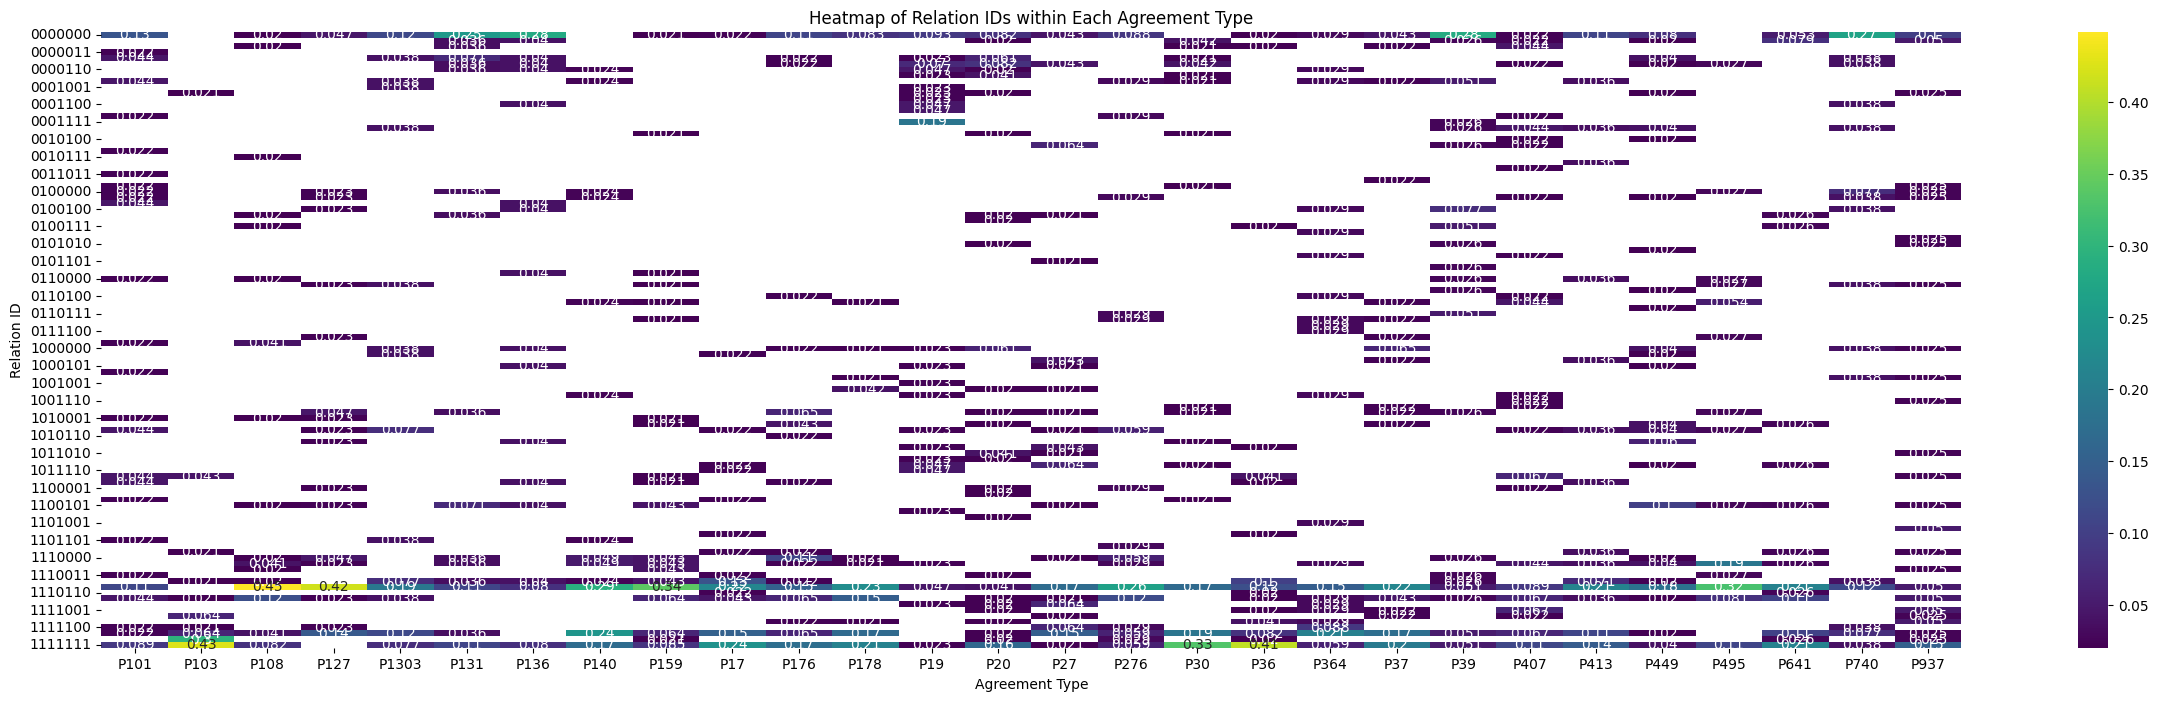

In [335]:
# Create a heatmap for the relation_ids DataFrame
plt.figure(figsize=(30, 8))
sns.heatmap(top_relation_ids, annot=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Relation IDs within Each Agreement Type')
plt.xlabel('Agreement Type')
plt.ylabel('Relation ID')
plt.show()

In [ ]:
# Experiment 3

In [336]:
def correct_position(df):
    correct_rank = []
    for i, row in df.iterrows():
        top_outputs = ast.literal_eval(row['model_top_outputs'])
        correct_output = row['attribute']
        ranks = [i for i, (token, _) in enumerate(top_outputs) if token == correct_output]
        if ranks:
            correct_rank.append(ranks[0] + 1)  # Convert to 1-based rank
        else:
            correct_rank.append(None)
    return correct_rank

result = result.assign(correct_rank=correct_position(result))

# Plot a histogram of the rank positions of the correct answer
plt.figure(figsize=(10, 6))
result['correct_rank'].dropna().plot(kind='hist', bins=5, alpha=0.75)
plt.xlabel('Rank Position of Correct Answer')
plt.ylabel('Frequency')
plt.title('Histogram of Correct Answer Position in Top Predictions')
plt.show()


KeyError: 'model_top_outputs'